# Medical Image Dataset Analysis

This notebook analyzes the medical image dataset containing chest X-rays with various pathological findings. It implements and compares three MLP-based models: a Baseline MLP, a Two-Branch MLP with Concatenation Fusion, and a Weighted Sum MLP.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch

def convert_numpy_types(data):
    if isinstance(data, dict): return {k: convert_numpy_types(v) for k, v in data.items()}
    elif isinstance(data, list): return [convert_numpy_types(i) for i in data]
    elif isinstance(data, np.integer): return int(data)
    elif isinstance(data, np.floating): return float(data)
    elif isinstance(data, np.ndarray): return data.tolist()
    return data

To run this notebook, downloading the dataset (or at least a sample of it) is necessary.
https://www.kaggle.com/datasets/nih-chest-xrays/data

I tried to use the `kaggle` API, to download the dataset, but it seems that the API cannot download the subfolders, so I suggest to download the dataset manually.


In [13]:
# Load the dataset metadata
data_path = 'dataset/Data_Entry_2017.csv'
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"First few rows:")
print(df.head())

print(f"Unique findings:")
all_findings = []
for findings in df['Finding Labels']:
    all_findings.extend(findings.split('|'))
unique_findings = sorted(set(all_findings))
print(unique_findings)

Dataset shape: (112120, 12)
First few rows:
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0      

In [ ]:
# Get list of actually downloaded images
image_dir = 'dataset/images'
if os.path.exists(image_dir):
    downloaded_images = set(os.listdir(image_dir))
    print(f"Total images downloaded: {len(downloaded_images)}")
else:
    print("Images directory not found!")
    downloaded_images = set()

# Filter the dataframe to only include downloaded images
original_size = len(df)
df_filtered = df[df['Image Index'].isin(downloaded_images)]
filtered_size = len(df_filtered)

print(f"Dataset filtering results:")
print(f"Original dataset size: {original_size}")
print(f"Filtered dataset size: {filtered_size}")
print(f"Images removed: {original_size - filtered_size}")
print(f"Percentage of data retained: {filtered_size/original_size*100:.2f}%")

# Update the main dataframe
df = df_filtered
print(f"Updated dataframe shape: {df.shape}")

Total images downloaded: 40000
Dataset filtering results:
Original dataset size: 112120
Filtered dataset size: 40000
Images removed: 72120
Percentage of data retained: 35.68%
Updated dataframe shape: (40000, 12)


In [15]:
# Show statistics about the filtered dataset
if len(df) > 0:
    print("=== Filtered Dataset Statistics ===")
    print(f"Total samples: {len(df)}")
    
    filtered_findings = []
    for findings in df['Finding Labels']:
        filtered_findings.extend(findings.split('|'))
    
    from collections import Counter
    finding_counts = Counter(filtered_findings)
    
    print(f"Finding distribution in filtered dataset:")
    for finding, count in finding_counts.most_common(5): 
        percentage = (count / len(df)) * 100
        print(f"  {finding}: {count} ({percentage:.1f}%)")
    
    print(f"Age distribution:")
    print(f"  Mean age: {df['Patient Age'].mean():.1f}")
    print(f"  Age range: {df['Patient Age'].min()} - {df['Patient Age'].max()}")
    
    print(f"Gender distribution:")
    gender_counts = df['Patient Gender'].value_counts()
    for gender, count in gender_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  {gender}: {count} ({percentage:.1f}%)")
    
    print(f"View Position distribution:")
    view_counts = df['View Position'].value_counts()
    for view, count in view_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  {view}: {count} ({percentage:.1f}%)")
else:
    print("No data to analyze in the filtered dataset.")

=== Filtered Dataset Statistics ===
Total samples: 40000
Finding distribution in filtered dataset:
  No Finding: 23068 (57.7%)
  Infiltration: 5886 (14.7%)
  Effusion: 4098 (10.2%)
  Atelectasis: 3918 (9.8%)
  Nodule: 2021 (5.1%)
Age distribution:
  Mean age: 46.9
  Age range: 1 - 412
Gender distribution:
  M: 21895 (54.7%)
  F: 18105 (45.3%)
View Position distribution:
  PA: 23800 (59.5%)
  AP: 16200 (40.5%)


In [16]:
# Load XrayCLIP model and processor
from transformers import AutoProcessor, AutoModel
from huggingface_hub import login

# token = "hf_yourtokenhere" 
# login(token=token, add_to_git_credential=False) 

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model_name = "StanfordAIMI/XraySigLIP__vit-b-16-siglip-512__webli"
clip_processor = AutoProcessor.from_pretrained(clip_model_name, trust_remote_code=True)
clip_model = AutoModel.from_pretrained(clip_model_name, trust_remote_code=True).to(device)
print(f"CLIP model and processor loaded. Using device: {device}")

CLIP model and processor loaded. Using device: cuda


In [17]:
import os
import numpy as np
import torch
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

def split_labels(labels_str):
    labels = [l.strip() for l in labels_str.split('|')]   
    if labels == ["No Finding"]:
        return []
    else:     
        return [l for l in labels if l != "No Finding"]

def get_multilabel_binarizer(df, labels_col='Finding Labels', split_labels_func=split_labels): 
    label_lists = df[labels_col].dropna().map(split_labels_func)
    all_labels = sorted(set(label for labels in label_lists for label in labels))
    print(f"Found {len(all_labels)} unique labels: {all_labels}")
    mlb = MultiLabelBinarizer(classes=all_labels)
    y = mlb.fit_transform(label_lists)
    return mlb, y

def multilabel_balanced_sample(df, labels_col, mlb, samples_per_label=100, random_state=42, include_no_finding=False):
    np.random.seed(random_state)
    selected_indices = set()    
    Y = mlb.transform(df[labels_col].apply(split_labels))    
    df_indices = df.index.tolist()    
    print(f"Balancing dataset with {samples_per_label} samples per label...")
    
    for i, label in enumerate(mlb.classes_):
        label_matrix_indices = np.where(Y[:, i] == 1)[0]
        label_df_indices = [df_indices[idx] for idx in label_matrix_indices]
        available_samples = len(label_df_indices)
        n_samples = min(samples_per_label, available_samples)
        if n_samples > 0:
            chosen_df_indices = np.random.choice(label_df_indices, n_samples, replace=False)
            selected_indices.update(chosen_df_indices)
    
    if include_no_finding:
        no_finding_mask = df[labels_col].apply(lambda x: "No Finding" in x)
        no_finding_df_indices = df[no_finding_mask].index.tolist()
        if len(no_finding_df_indices) > 0:
            n_no_finding_samples = min(samples_per_label, len(no_finding_df_indices))
            chosen_no_finding = np.random.choice(no_finding_df_indices, n_no_finding_samples, replace=False)
            selected_indices.update(chosen_no_finding)
    
    balanced_df = df.loc[list(selected_indices)].sample(frac=1, random_state=random_state).reset_index(drop=True)
    print(f"Balanced dataset size: {len(balanced_df)} (from {len(df)} original samples)")
    return balanced_df

In [18]:
import os
import numpy as np
import torch
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
  
class MedicalImageDataset(Dataset):
    def __init__(self, image_paths, labels, image_dir, processor, apply_feature_transformations=True):
        self.image_paths = image_paths
        self.labels = labels
        self.image_dir = image_dir
        self.processor = processor
        self.apply_feature_transformations = apply_feature_transformations
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_paths[idx])
        try:
            image = Image.open(img_path).convert("RGB")
            if self.apply_feature_transformations:
                processed = self.processor(images=image, return_tensors="pt")
                for key in processed:
                    processed[key] = processed[key].squeeze(0)
                return processed, torch.FloatTensor(self.labels[idx])
            else:
                return image, torch.FloatTensor(self.labels[idx])
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, torch.FloatTensor(self.labels[idx])                
 
# ==============================================================================
# MAIN EXECUTION - DATASET SETUP
# ==============================================================================
print("Setting up multilabel classification...")
print(f"Original dataset size: {len(df_filtered)}")

mlb, y_all = get_multilabel_binarizer(df_filtered, split_labels_func=split_labels) 

num_images_per_label = 100 
df_balanced = multilabel_balanced_sample(
    df_filtered, 
    'Finding Labels', 
    mlb,
    samples_per_label=num_images_per_label, 
    random_state=42,
    include_no_finding=True
)

batch_paths = df_balanced['Image Index'].tolist()
labels_balanced = mlb.transform(df_balanced['Finding Labels'].apply(split_labels))
print(f"Final balanced dataset shape (labels): {labels_balanced.shape}")

print("Creating medical image dataset...")
medical_dataset = MedicalImageDataset(
    image_paths=batch_paths,
    labels=labels_balanced,
    image_dir=image_dir,
    processor=clip_processor,
    apply_feature_transformations=True
)
print(f"Dataset preparation complete! Total samples in medical_dataset: {len(medical_dataset)}")

Setting up multilabel classification...
Original dataset size: 40000
Found 14 unique labels: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Balancing dataset with 100 samples per label...
Balanced dataset size: 1452 (from 40000 original samples)
Final balanced dataset shape (labels): (1452, 14)
Creating medical image dataset...
Dataset preparation complete! Total samples in medical_dataset: 1452


# Baseline MLP

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, hamming_loss
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes, dropout_rate=0.3):
        super(MLPClassifier, self).__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, num_classes))
        self.network = nn.Sequential(*layers)
        self.logit_shifts = nn.Parameter(torch.zeros(num_classes))
        
    def forward(self, x):
        logits = self.network(x)
        shifted_logits = logits - self.logit_shifts
        return shifted_logits

def extract_features_on_demand(dataset, model, device, batch_size=16):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_features = []
    all_labels = []
    with torch.no_grad():
        for batch_data, batch_labels in tqdm(dataloader, desc="Extracting features"):
            if batch_data is None: continue 
            for key in batch_data:
                batch_data[key] = batch_data[key].to(device)
            features = model.get_image_features(**batch_data)            
            features = features / features.norm(dim=-1, keepdim=True)
            all_features.append(features.cpu().numpy())
            all_labels.append(batch_labels.numpy())
    if not all_features: return np.array([]), np.array([])
    return np.vstack(all_features), np.vstack(all_labels)

def train_mlp_classifier(dataset, model, mlb, device, test_size=0.2, random_state=42): 
    print("Setting up MLP classifier training...")
    noise_std = 0.01
    
    indices = list(range(len(dataset)))
    train_indices, test_indices = train_test_split(
        indices, test_size=test_size, random_state=random_state
    )
    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)

    print(f"Training set size: {len(train_dataset)}, Test set size: {len(test_dataset)}")
    
    print("Extracting training features...")
    X_train, y_train = extract_features_on_demand(train_dataset, model, device, batch_size=128)
    if X_train.size == 0:
        print("No training features extracted. Aborting MLP training.")
        return None, [], [], (None, None, None, None)

    print("Extracting test features...")
    X_test, y_test = extract_features_on_demand(test_dataset, model, device, batch_size=128)
    if X_test.size == 0:
        print("No test features extracted. Aborting MLP training.")
        return None, [], [], (X_train, None, y_train, None)

    print(f"Training features shape: {X_train.shape}")
    print(f"Test features shape: {X_test.shape}")
    
    class FeatureDataset(Dataset):
        def __init__(self, features, labels):
            self.features = torch.FloatTensor(features)
            self.labels = torch.FloatTensor(labels)
        def __len__(self): return len(self.features)
        def __getitem__(self, idx): return self.features[idx], self.labels[idx]
    
    train_feature_dataset = FeatureDataset(X_train, y_train)
    test_feature_dataset = FeatureDataset(X_test, y_test)
    
    train_loader = DataLoader(train_feature_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_feature_dataset, batch_size=32, shuffle=False)
    
    input_dim = X_train.shape[1]
    num_classes = y_train.shape[1]
    hidden_dims = [512, 256, 128]  
    
    mlp_model_instance = MLPClassifier( 
        input_dim=input_dim, hidden_dims=hidden_dims, num_classes=num_classes, dropout_rate=0.3
    ).to(device)
    
    print(f"MLP Model architecture: Input dim: {input_dim}, Hidden dims: {hidden_dims}, Output dim: {num_classes}")
    
    criterion = nn.BCEWithLogitsLoss() 
    optimizer = optim.Adam(mlp_model_instance.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)
    
    num_epochs = 50 
    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    
    print(f"Starting training for {num_epochs} epochs...")
    for epoch in range(num_epochs):
        mlp_model_instance.train()
        train_loss = 0.0
        for batch_features, batch_labels in train_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            if mlp_model_instance.training and noise_std > 0:
                batch_features = batch_features + torch.randn_like(batch_features) * noise_std
            optimizer.zero_grad()
            outputs = mlp_model_instance(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        mlp_model_instance.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_features, batch_labels in test_loader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                outputs = mlp_model_instance(batch_features)
                loss = criterion(outputs, batch_labels)
                val_loss += loss.item()
        
        avg_train_loss, avg_val_loss = train_loss / len(train_loader), val_loss / len(test_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(mlp_model_instance.state_dict(), 'best_mlp_model.pth')
        
        if (epoch + 1) % 10 == 0: 
            print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    mlp_model_instance.load_state_dict(torch.load('best_mlp_model.pth'))
    return mlp_model_instance, train_losses, val_losses, (X_train, X_test, y_train, y_test)

Training Baseline MLP classifier ...
Setting up MLP classifier training...
Training set size: 1161, Test set size: 291
Extracting training features...


Extracting features: 100%|██████████| 10/10 [01:40<00:00, 10.06s/it]


Extracting test features...


Extracting features: 100%|██████████| 3/3 [00:24<00:00,  8.01s/it]


Training features shape: (1161, 768)
Test features shape: (291, 768)
MLP Model architecture: Input dim: 768, Hidden dims: [512, 256, 128], Output dim: 14
Starting training for 50 epochs...
Epoch [10/50] - Train Loss: 0.2739, Val Loss: 0.2957, LR: 0.001000
Epoch [20/50] - Train Loss: 0.2288, Val Loss: 0.2957, LR: 0.000100
Epoch [30/50] - Train Loss: 0.2242, Val Loss: 0.2957, LR: 0.000001
Epoch [40/50] - Train Loss: 0.2248, Val Loss: 0.2961, LR: 0.000000
Epoch [50/50] - Train Loss: 0.2240, Val Loss: 0.2952, LR: 0.000000
Baseline MLP Training completed!


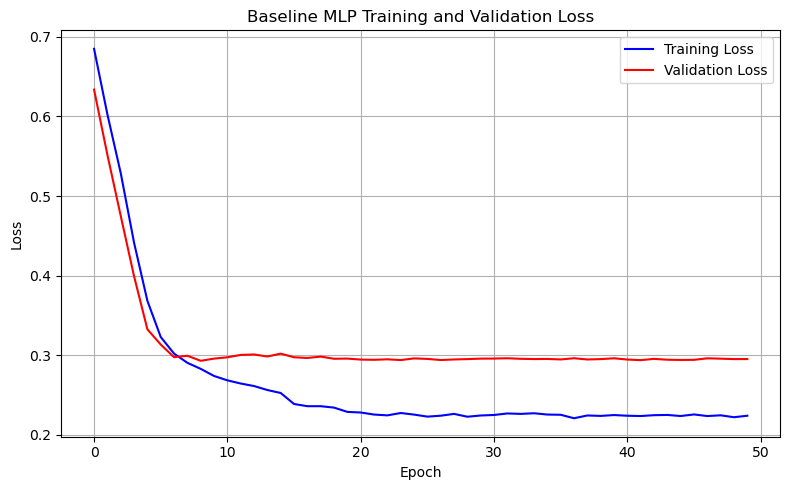

Final training loss: 0.2240
Final validation loss: 0.2952
Best validation loss: 0.2930 (epoch 9)


In [20]:
# ==============================================================================
# TRAIN BASELINE MLP CLASSIFIER
# ==============================================================================
print("Training Baseline MLP classifier ...")

mlp_model, train_losses, val_losses, (X_train, X_test, y_train, y_test) = train_mlp_classifier(
    medical_dataset,
    clip_model,
    mlb,
    device,
    test_size=0.2,
    random_state=42
)

if mlp_model is not None:
    print("Baseline MLP Training completed!")
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 5)) 
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Baseline MLP Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Final training loss: {train_losses[-1]:.4f}")
    print(f"Final validation loss: {val_losses[-1]:.4f}")
    print(f"Best validation loss: {min(val_losses):.4f} (epoch {val_losses.index(min(val_losses))+1})")
else:
    print("Baseline MLP training failed or was aborted.")
# ==============================================================================

In [21]:
# ==============================================================================
# EVALUATE BASELINE MLP CLASSIFIER PERFORMANCE
# ==============================================================================
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, hamming_loss
from tqdm import tqdm
import json 

def evaluate_multilabel_classifier(model, X_test_eval, y_test_eval, mlb_eval, device_eval, threshold=0.5): 
    if X_test_eval is None or y_test_eval is None:
        print("Skipping evaluation due to missing test data.")
        return {}, [], np.array([]), np.array([])
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test_eval).to(device_eval)
        shifted_logits = model(X_test_tensor)
        probabilities = torch.sigmoid(shifted_logits)
        predictions = (probabilities > threshold).cpu().numpy().astype(int)
        probabilities_np = probabilities.cpu().numpy()
    
    metrics = {}
    metrics['hamming_loss'] = hamming_loss(y_test_eval, predictions)
    metrics['exact_match_ratio'] = accuracy_score(y_test_eval, predictions)
    
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(y_test_eval, predictions, average='macro', zero_division=0)
    metrics['macro_precision'], metrics['macro_recall'], metrics['macro_f1'] = macro_precision, macro_recall, macro_f1
    
    micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(y_test_eval, predictions, average='micro', zero_division=0)
    metrics['micro_precision'], metrics['micro_recall'], metrics['micro_f1'] = micro_precision, micro_recall, micro_f1
    
    labels = list(range(len(mlb_eval.classes_)))

    per_class_p, per_class_r, per_class_f1, per_class_s = precision_recall_fscore_support(y_test_eval, predictions, average=None, zero_division=0,labels=labels)
    class_metrics = [{'class': name, 'precision': per_class_p[i], 'recall': per_class_r[i], 'f1': per_class_f1[i], 'support': per_class_s[i]} 
                     for i, name in enumerate(mlb_eval.classes_)]
    
    return metrics, class_metrics, predictions, probabilities_np

print("Evaluating Baseline MLP classifier...")
baseline_metrics, baseline_class_metrics, baseline_predictions, baseline_probabilities = evaluate_multilabel_classifier(
    mlp_model, X_test, y_test, mlb, device, threshold=0.5
)

print("="*60 + "\nOVERALL BASELINE CLASSIFICATION METRICS\n" + "="*60)
print(f"Exact Match Ratio: {baseline_metrics.get('exact_match_ratio', 0):.4f}")
print(f"Hamming Loss: {baseline_metrics.get('hamming_loss', 0):.4f}")

print("="*60 + "\nBASELINE PER-CLASS CLASSIFICATION METRICS\n" + "="*60)

serializable_baseline_metrics = convert_numpy_types(baseline_metrics)
serializable_baseline_class_metrics = convert_numpy_types(baseline_class_metrics)

with open('baseline_mlp_metrics.json', 'w') as f: json.dump(serializable_baseline_metrics, f, indent=4)
with open('baseline_mlp_class_metrics.json', 'w') as f: json.dump(serializable_baseline_class_metrics, f, indent=4)
print("Baseline MLP metrics saved.")


Evaluating Baseline MLP classifier...
OVERALL BASELINE CLASSIFICATION METRICS
Exact Match Ratio: 0.1340
Hamming Loss: 0.1176
BASELINE PER-CLASS CLASSIFICATION METRICS
Baseline MLP metrics saved.


In [22]:
# ==============================================================================
# INFERENCE FUNCTION (REUSABLE)
# ==============================================================================
def predict_image_conditions(image_path, mlp_model_inf, vision_model_inf, processor_inf, mlb_inf, device_inf, threshold=0.5, top_k=5, prompt_features_inf=None):
    img = Image.open(image_path).convert("RGB")
    vision_model_inf.eval()
    mlp_model_inf.eval()
    
    with torch.no_grad():
        inputs = processor_inf(images=[img], return_tensors="pt").to(device_inf)
        image_features = vision_model_inf.get_image_features(**inputs)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        
        if prompt_features_inf is not None:
            # This case is for TwoBranchMLP or WeightedSumMLP that take two inputs
            current_batch_size = image_features.shape[0]
            if prompt_features_inf.ndim == 1:
                prompt_features_inf = prompt_features_inf.unsqueeze(0)
            prompt_feats_batch = prompt_features_inf.to(device_inf).expand(current_batch_size, -1)
            shifted_logits = mlp_model_inf(image_features, prompt_feats_batch)
        else:
            # This case is for MLPClassifier that takes one input
            shifted_logits = mlp_model_inf(image_features)
            
        probabilities = torch.sigmoid(shifted_logits).cpu().numpy()[0] # Probabilities for all classes
    
    # Get predicted conditions (above threshold)
    predicted_indices = np.where(probabilities > threshold)[0]
    predicted_conditions_list = [mlb_inf.classes_[i] for i in predicted_indices]

    # Get top_k predictions with their probabilities
    num_classes_total = len(mlb_inf.classes_)
    actual_top_k = top_k
    if top_k == -1 or top_k > num_classes_total:
        actual_top_k = num_classes_total
        
    top_k_indices = np.argsort(probabilities)[::-1][:actual_top_k]
    top_predictions_list = []
    for i in top_k_indices:
        condition_name = mlb_inf.classes_[i]
        prob = probabilities[i]
        is_predicted = prob > threshold # Check if this specific top-k condition is above threshold
        top_predictions_list.append({
            'condition': condition_name,
            'probability': prob,
            'predicted': is_predicted 
        })
        
    results = {
        'predicted_conditions': predicted_conditions_list, # List of condition names predicted above threshold
        'top_predictions': top_predictions_list, # List of dicts for top_k conditions (name, prob, is_predicted)
        'all_probabilities': probabilities # Numpy array of probabilities for all classes
    }
    return results, img

# Two-Branch MLP (Concatenation Fusion) Analysis
This section implements and evaluates a multi-branch MLP that uses both image features and text prompt ensemble features.

In [23]:
# Prompt Engineering for Two-Branch MLP
pathologies_concat = mlb.classes_ # Reusing mlb from baseline

prompt_templates_positive_concat = [
    "signs of {finding}", "indication of {finding}", "evidence of {finding}",
    "characteristic of {finding}", "presence of {finding}"
]

prompt_dictionary_concat = {}
for pathology in pathologies_concat:
    prompts_pos = [template.format(finding=pathology) for template in prompt_templates_positive_concat]
    prompt_dictionary_concat[pathology] = {"positive": prompts_pos}

# print(f"Prompts for {pathologies_concat[0]}: {prompt_dictionary_concat[pathologies_concat[0]]['positive'][:2]}...")
print(f"Total pathologies with prompts for Two-Branch MLP: {len(prompt_dictionary_concat)}")

Total pathologies with prompts for Two-Branch MLP: 14


In [24]:
# Feature Extraction Ensemble for Two-Branch MLP
from tqdm import tqdm 

def extract_prompt_features_concat(prompt_dict, clip_model_feat, clip_processor_feat, device_feat):
    all_text_features = {}
    with torch.no_grad():
        for pathology, prompts in tqdm(prompt_dict.items(), desc="Processing prompts (Concat MLP)"):
            pos_prompts = prompts['positive']
            inputs_pos = clip_processor_feat(text=pos_prompts, return_tensors="pt", padding=True, truncation=True).to(device_feat)
            features_pos = clip_model_feat.get_text_features(**inputs_pos)
            features_pos = features_pos / features_pos.norm(dim=-1, keepdim=True)
            all_text_features[pathology] = {"positive": features_pos.mean(dim=0).cpu()}
    return all_text_features

aggregated_prompt_features_concat = extract_prompt_features_concat(
    prompt_dictionary_concat, clip_model, clip_processor, device
)

feature_dim_concat = aggregated_prompt_features_concat[pathologies_concat[0]]['positive'].shape[0]
prompt_mega_vector_template_concat = torch.zeros((len(pathologies_concat), 1, feature_dim_concat))
for i, pathology in enumerate(pathologies_concat):
    prompt_mega_vector_template_concat[i, 0, :] = aggregated_prompt_features_concat[pathology]['positive']

print(f"Shape of aggregated prompt mega-vector template (Concat MLP): {prompt_mega_vector_template_concat.shape}")

Processing prompts (Concat MLP): 100%|██████████| 14/14 [00:00<00:00, 72.15it/s]

Shape of aggregated prompt mega-vector template (Concat MLP): torch.Size([14, 1, 768])


In [25]:
# Two-Branch MLP Architecture with Concatenation Fusion
import torch.nn as nn 

class TwoBranchMLP(nn.Module):
    def __init__(self, image_input_dim, prompt_input_dim, hidden_dim, num_classes, dropout_rate=0.3):
        super(TwoBranchMLP, self).__init__()
        self.image_branch = nn.Sequential(
            nn.Linear(image_input_dim, hidden_dim), nn.ReLU(),
            nn.BatchNorm1d(hidden_dim), nn.Dropout(dropout_rate)
        )
        self.prompt_branch = nn.Sequential(
            nn.Linear(prompt_input_dim, hidden_dim * 2), nn.ReLU(), nn.BatchNorm1d(hidden_dim * 2), nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim * 2, hidden_dim), nn.ReLU(), nn.BatchNorm1d(hidden_dim), nn.Dropout(dropout_rate)
        )
        self.output_layer = nn.Linear(hidden_dim * 2, num_classes)
        self.logit_shifts = nn.Parameter(torch.zeros(num_classes))

    def forward(self, image_features, prompt_mega_vector):
        image_embedding = self.image_branch(image_features)
        prompt_embedding = self.prompt_branch(prompt_mega_vector)
        fused_embedding = torch.cat((image_embedding, prompt_embedding), dim=1)
        output_logits = self.output_layer(fused_embedding)
        return output_logits - self.logit_shifts

# X_train, y_train should be available from baseline MLP training
if X_train is not None and y_train is not None:
    image_feat_dim_concat = X_train.shape[1]
    prompt_feat_flat_dim_concat = prompt_mega_vector_template_concat.shape[0] * \
                                 prompt_mega_vector_template_concat.shape[1] * \
                                 prompt_mega_vector_template_concat.shape[2]
    hidden_d_concat = 256
    num_classes_mlp_concat = y_train.shape[1]

    two_branch_model_concat_fusion = TwoBranchMLP(
        image_input_dim=image_feat_dim_concat, prompt_input_dim=prompt_feat_flat_dim_concat,
        hidden_dim=hidden_d_concat, num_classes=num_classes_mlp_concat, dropout_rate=0.3
    ).to(device)
    print(f"Two-Branch MLP (Concat Fusion) initialized. Params: {sum(p.numel() for p in two_branch_model_concat_fusion.parameters()):,}")
    prompt_mega_vector_flat_concat = prompt_mega_vector_template_concat.flatten().unsqueeze(0)
else:
    print("Skipping Two-Branch MLP setup as X_train/y_train is not available.")
    two_branch_model_concat_fusion = None

Two-Branch MLP (Concat Fusion) initialized. Params: 5,842,972


Training Two-Branch MLP with Concatenation Fusion...
Starting Two-Branch MLP training (best_two_branch_mlp_concat_model.pth) for 60 epochs...


Epoch [10/60] - Train Loss: 0.2741, Val Loss: 3.1064


Epoch [20/60] - Train Loss: 0.2589, Val Loss: 0.4585


Epoch [30/60] - Train Loss: 0.2589, Val Loss: 0.4944


Epoch [40/60] - Train Loss: 0.2578, Val Loss: 0.2981


Epoch [50/60] - Train Loss: 0.2599, Val Loss: 0.2940


Epoch [60/60] - Train Loss: 0.2613, Val Loss: 0.2939
Training finished. Best model loaded from best_two_branch_mlp_concat_model.pth


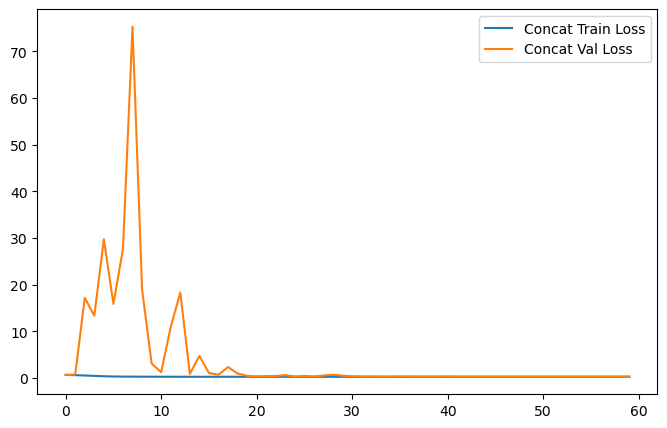

Evaluating Two-Branch MLP (Concatenation Fusion)...


Evaluating Two-Branch Model: 100%|██████████| 10/10 [00:00<00:00, 1003.09it/s]


Two-Branch MLP (Concat) metrics updated in comparison files.


In [26]:
# Training and Evaluation of the Two-Branch MLP (Concatenation Fusion)
from torch.utils.data import Dataset, DataLoader 
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, hamming_loss 
from tqdm import tqdm 
import json 

class MultiModalFeatureDataset(Dataset): 
    def __init__(self, image_features, labels, prompt_mega_vector_flat_ds): 
        self.image_features = torch.FloatTensor(image_features)
        self.labels = torch.FloatTensor(labels)
        self.prompt_mega_vector_flat_ds = prompt_mega_vector_flat_ds
        
    def __len__(self): return len(self.image_features)
    def __getitem__(self, idx): return self.image_features[idx], self.prompt_mega_vector_flat_ds.squeeze(0), self.labels[idx]

def train_two_branch_mlp(model, train_loader, test_loader, device_train, prompt_vector_gpu, save_path, epochs=50, lr=0.001): 
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.2) 
    train_losses_list, val_losses_list, best_val_loss_train = [], [], float('inf')
    noise_std_tb = 0.01
    
    print(f"Starting Two-Branch MLP training ({save_path}) for {epochs} epochs...")
    for epoch in range(epochs):
        model.train()
        current_train_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} Train", leave=False)
        for img_feats, _, batch_labels in train_pbar: # prompt_feats from dataset is ignored, global one used
            img_feats, batch_labels = img_feats.to(device_train), batch_labels.to(device_train)
            current_batch_size = img_feats.shape[0]
            prompt_feats_batch = prompt_vector_gpu.expand(current_batch_size, -1)
            if model.training and noise_std_tb > 0: img_feats = img_feats + torch.randn_like(img_feats) * noise_std_tb
            optimizer.zero_grad()
            outputs = model(img_feats, prompt_feats_batch)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            current_train_loss += loss.item()
            train_pbar.set_postfix(loss=loss.item())
        
        model.eval()
        current_val_loss = 0.0
        val_pbar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{epochs} Val", leave=False)
        with torch.no_grad():
            for img_feats, _, batch_labels in val_pbar:
                img_feats, batch_labels = img_feats.to(device_train), batch_labels.to(device_train)
                current_batch_size = img_feats.shape[0]
                prompt_feats_batch = prompt_vector_gpu.expand(current_batch_size, -1)
                outputs = model(img_feats, prompt_feats_batch)
                loss = criterion(outputs, batch_labels)
                current_val_loss += loss.item()
                val_pbar.set_postfix(loss=loss.item())
        
        avg_train_loss, avg_val_loss = current_train_loss/len(train_loader), current_val_loss/len(test_loader)
        train_losses_list.append(avg_train_loss); val_losses_list.append(avg_val_loss)
        scheduler.step(avg_val_loss)
        if avg_val_loss < best_val_loss_train:
            best_val_loss_train = avg_val_loss
            torch.save(model.state_dict(), save_path)
        if (epoch + 1) % 10 == 0: print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
            
    model.load_state_dict(torch.load(save_path))
    print(f"Training finished. Best model loaded from {save_path}")
    return model, train_losses_list, val_losses_list

def evaluate_two_branch_mlp(model, test_loader, device_eval, prompt_vector_gpu, mlb_eval, num_classes_eval, threshold=0.5):
    model.eval()
    all_preds, all_true, all_probs_list = [], [], []
    with torch.no_grad():
        for img_feats, _, batch_labels in tqdm(test_loader, desc="Evaluating Two-Branch Model"):
            img_feats, batch_labels_np = img_feats.to(device_eval), batch_labels.numpy()
            current_batch_size = img_feats.shape[0]
            prompt_feats_batch = prompt_vector_gpu.expand(current_batch_size, -1)
            shifted_logits = model(img_feats, prompt_feats_batch)
            probabilities = torch.sigmoid(shifted_logits).cpu().numpy()
            predictions = (probabilities > threshold).astype(int)
            all_preds.append(predictions); all_true.append(batch_labels_np); all_probs_list.append(probabilities)
            
    y_pred_final, y_true_final, probabilities_final = np.vstack(all_preds), np.vstack(all_true), np.vstack(all_probs_list)
    metrics_tb = {'hamming_loss': hamming_loss(y_true_final, y_pred_final), 
                  'exact_match_ratio': accuracy_score(y_true_final, y_pred_final)}
    p_ma, r_ma, f1_ma, _ = precision_recall_fscore_support(y_true_final, y_pred_final, average='macro', zero_division=0)
    metrics_tb.update({'macro_precision': p_ma, 'macro_recall': r_ma, 'macro_f1': f1_ma})
    p_mi, r_mi, f1_mi, _ = precision_recall_fscore_support(y_true_final, y_pred_final, average='micro', zero_division=0)
    metrics_tb.update({'micro_precision': p_mi, 'micro_recall': r_mi, 'micro_f1': f1_mi})
    
    p_cl, r_cl, f1_cl, s_cl = precision_recall_fscore_support(y_true_final, y_pred_final, average=None, zero_division=0, labels=list(range(num_classes_eval)))
    class_metrics_tb_list = [{'class': name, 'precision': p_cl[i], 'recall': r_cl[i], 'f1': f1_cl[i], 'support': s_cl[i]}
                             for i, name in enumerate(mlb_eval.classes_)]
    return metrics_tb, class_metrics_tb_list, y_pred_final, probabilities_final

if 'all_metrics_comparison' not in globals(): all_metrics_comparison = {} 
if 'all_class_metrics_comparison' not in globals(): all_class_metrics_comparison = {}

if two_branch_model_concat_fusion is not None and X_train is not None and y_train is not None and X_test is not None and y_test is not None:
    train_tb_dataset_concat = MultiModalFeatureDataset(X_train, y_train, prompt_mega_vector_flat_concat.cpu()) 
    test_tb_dataset_concat = MultiModalFeatureDataset(X_test, y_test, prompt_mega_vector_flat_concat.cpu()) 
    train_tb_loader_concat = DataLoader(train_tb_dataset_concat, batch_size=32, shuffle=True)
    test_tb_loader_concat = DataLoader(test_tb_dataset_concat, batch_size=32, shuffle=False)
    
    prompt_mega_vector_flat_gpu_concat = prompt_mega_vector_flat_concat.to(device)
    
    print("Training Two-Branch MLP with Concatenation Fusion...")
    two_branch_model_concat_fusion_trained, tb_concat_train_losses, tb_concat_val_losses = train_two_branch_mlp(
        two_branch_model_concat_fusion, train_tb_loader_concat, test_tb_loader_concat, device, 
        prompt_mega_vector_flat_gpu_concat, 'best_two_branch_mlp_concat_model.pth', epochs=60, lr=0.0003
    )
    # Plotting and printing loss for concat model
    plt.figure(figsize=(8,5)); plt.plot(tb_concat_train_losses, label='Concat Train Loss'); plt.plot(tb_concat_val_losses, label='Concat Val Loss'); plt.legend(); plt.show()
    
    print("Evaluating Two-Branch MLP (Concatenation Fusion)...")
    metrics_2branch_concat, class_metrics_2branch_concat, _, _ = evaluate_two_branch_mlp(
        two_branch_model_concat_fusion_trained, test_tb_loader_concat, device, 
        prompt_mega_vector_flat_gpu_concat, mlb, num_classes_mlp_concat, threshold=0.5
    )
    all_metrics_comparison["two_branch_mlp_concat"] = metrics_2branch_concat
    all_class_metrics_comparison["two_branch_mlp_concat"] = class_metrics_2branch_concat
    # Printing metrics for concat model
    with open('all_metrics_comparison.json', 'w') as f: json.dump(convert_numpy_types(all_metrics_comparison), f, indent=4)
    with open('all_class_metrics_comparison.json', 'w') as f: json.dump(convert_numpy_types(all_class_metrics_comparison), f, indent=4)
    print("Two-Branch MLP (Concat) metrics updated in comparison files.")
else:
    print("Skipping Two-Branch MLP training/evaluation due to missing prerequisites.")

# Weighted Sum MLP Analysis
This section implements and evaluates an MLP that uses a weighted sum of image features and text prompt features.

In [ ]:
# ==============================================================================
# PREPARE PROMPT FEATURES FOR WEIGHTED SUM MLP
# ==============================================================================
# Reuse the ensembled prompt features from the Two-Branch MLP (Concatenation Fusion)



if 'prompt_mega_vector_template_concat' not in locals() and 'prompt_mega_vector_template_concat' not in globals():
    raise NameError("Variable 'prompt_mega_vector_template_concat' not found. \nEnsure the 'PROMPT ENGINEERING FOR TWO-BRANCH MLP (CONCATENATION FUSION)' cell has been run successfully.")

if 'mlb' not in locals() and 'mlb' not in globals():
    raise NameError("Variable 'mlb' not found. \nEnsure it is defined and fitted in the setup cells.")

if 'pathologies' not in locals() and 'pathologies' not in globals():
    if 'mlb' in locals() or 'mlb' in globals():
        pathologies = mlb.classes_
        print("Defined 'pathologies' from mlb.classes_ for the Weighted Sum MLP section.")
    else:
        raise NameError("Variable 'pathologies' not found and 'mlb' is not available to define it. \nEnsure 'pathologies' is defined in the setup cells.")

prompt_mega_vector_template_ws = prompt_mega_vector_template_concat
print("Reused prompt_mega_vector_template_concat for Weighted Sum MLP.")
print(f"Shape of prompt_mega_vector_template_ws: {prompt_mega_vector_template_ws.shape}")
print(f"Number of pathologies considered: {len(pathologies)}")

# Verify consistency
if prompt_mega_vector_template_ws.shape[0] != len(pathologies):
    print(f"Warning: Mismatch between prompt features dimension ({prompt_mega_vector_template_ws.shape[0]}) and number of pathologies ({len(pathologies)}).")
    print("Ensure 'pathologies' and 'prompt_mega_vector_template_concat' are consistent.")

Defined 'pathologies' from mlb.classes_ for the Weighted Sum MLP section.
Reused prompt_mega_vector_template_concat for Weighted Sum MLP.
Shape of prompt_mega_vector_template_ws: torch.Size([14, 1, 768])
Number of pathologies considered: 14


In [28]:
# New MLP Architecture: Weighted Sum MLP
import torch.nn as nn 

class WeightedSumMLP(nn.Module):
    def __init__(self, image_input_dim, prompt_input_dim, mlp_hidden_dims, num_classes, dropout_rate=0.3):
        super(WeightedSumMLP, self).__init__()
        self.prompt_projection = nn.Linear(prompt_input_dim, image_input_dim)
        self.w_img = nn.Parameter(torch.ones(image_input_dim))
        self.w_prompt = nn.Parameter(torch.ones(image_input_dim))
        layers = []
        current_mlp_input_dim = image_input_dim
        for h_dim in mlp_hidden_dims:
            layers.extend([nn.Linear(current_mlp_input_dim, h_dim), nn.ReLU(), nn.BatchNorm1d(h_dim), nn.Dropout(dropout_rate)])
            current_mlp_input_dim = h_dim
        layers.append(nn.Linear(current_mlp_input_dim, num_classes))
        self.network = nn.Sequential(*layers)
        self.logit_shifts = nn.Parameter(torch.zeros(num_classes))

    def forward(self, image_features, prompt_mega_vector):
        projected_prompt_features = torch.relu(self.prompt_projection(prompt_mega_vector))
        combined_features = (self.w_img * image_features) + (self.w_prompt * projected_prompt_features)
        output_logits = self.network(combined_features)
        return output_logits - self.logit_shifts

if X_train is not None and y_train is not None:
    image_feat_dim_ws = X_train.shape[1]
    prompt_feat_flat_dim_ws = prompt_mega_vector_template_ws.shape[0] * \
                             prompt_mega_vector_template_ws.shape[1] * \
                             prompt_mega_vector_template_ws.shape[2]
    mlp_hidden_dims_ws = [512, 256]
    num_classes_mlp_ws = y_train.shape[1]

    weighted_sum_model = WeightedSumMLP(
        image_input_dim=image_feat_dim_ws, prompt_input_dim=prompt_feat_flat_dim_ws,
        mlp_hidden_dims=mlp_hidden_dims_ws, num_classes=num_classes_mlp_ws, dropout_rate=0.3
    ).to(device)
    print(f"Weighted Sum MLP initialized. Params: {sum(p.numel() for p in weighted_sum_model.parameters()):,}")
    prompt_mega_vector_flat_ws = prompt_mega_vector_template_ws.flatten().unsqueeze(0)
else:
    print("Skipping Weighted Sum MLP setup as X_train/y_train is not available.")
    weighted_sum_model = None

Weighted Sum MLP initialized. Params: 8,790,044


Training Weighted Sum MLP...
Starting Two-Branch MLP training (best_weighted_sum_mlp_model.pth) for 60 epochs...


Epoch [10/60] - Train Loss: 0.4018, Val Loss: 0.3932


Epoch [20/60] - Train Loss: 0.2483, Val Loss: 0.2914


Epoch [30/60] - Train Loss: 0.2227, Val Loss: 0.2917


Epoch [40/60] - Train Loss: 0.2127, Val Loss: 0.2944


Epoch [50/60] - Train Loss: 0.2164, Val Loss: 0.2949


Epoch [60/60] - Train Loss: 0.2180, Val Loss: 0.2947
Training finished. Best model loaded from best_weighted_sum_mlp_model.pth


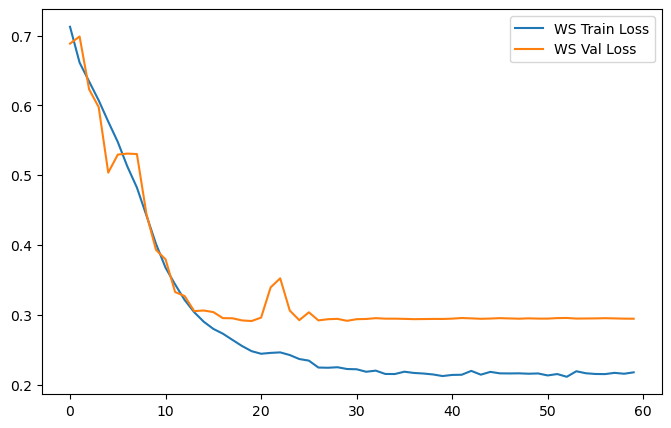

Evaluating Weighted Sum MLP...


Evaluating Two-Branch Model: 100%|██████████| 10/10 [00:00<00:00, 950.85it/s]

Weighted Sum MLP metrics updated in comparison files.


In [29]:
# Training and Evaluation of the Weighted Sum MLP
from torch.utils.data import Dataset, DataLoader 
from tqdm import tqdm 
import json 

# Will use MultiModalFeatureDataset from cell f0b75f43

# train_fused_mlp and evaluate_fused_mlp are similar to train_two_branch_mlp and evaluate_two_branch_mlp
# We can use the previously defined train_two_branch_mlp and evaluate_two_branch_mlp functions.

if 'all_metrics_comparison' not in globals(): all_metrics_comparison = {} 
if 'all_class_metrics_comparison' not in globals(): all_class_metrics_comparison = {}

if weighted_sum_model is not None and X_train is not None and y_train is not None and X_test is not None and y_test is not None:
    train_fused_dataset_ws = MultiModalFeatureDataset(X_train, y_train, prompt_mega_vector_flat_ws.cpu()) 
    test_fused_dataset_ws = MultiModalFeatureDataset(X_test, y_test, prompt_mega_vector_flat_ws.cpu())   
    train_fused_loader_ws = DataLoader(train_fused_dataset_ws, batch_size=32, shuffle=True)
    test_fused_loader_ws = DataLoader(test_fused_dataset_ws, batch_size=32, shuffle=False)

    prompt_mega_vector_flat_gpu_ws = prompt_mega_vector_flat_ws.to(device)

    print("Training Weighted Sum MLP...")
    # Using the generic train_two_branch_mlp function structure
    weighted_sum_model_trained, ws_train_losses, ws_val_losses = train_two_branch_mlp( 
        weighted_sum_model, train_fused_loader_ws, test_fused_loader_ws, device,
        prompt_mega_vector_flat_gpu_ws, 'best_weighted_sum_mlp_model.pth', epochs=60, lr=0.0003
    )
    # Plotting and printing loss for WS model
    plt.figure(figsize=(8,5)); plt.plot(ws_train_losses, label='WS Train Loss'); plt.plot(ws_val_losses, label='WS Val Loss'); plt.legend(); plt.show()

    print("Evaluating Weighted Sum MLP...")
    # Using the generic evaluate_two_branch_mlp function structure
    metrics_ws, class_metrics_ws, _, _ = evaluate_two_branch_mlp( 
        weighted_sum_model_trained, test_fused_loader_ws, device,
        prompt_mega_vector_flat_gpu_ws, mlb, num_classes_mlp_ws, threshold=0.5
    )
    all_metrics_comparison["weighted_sum_mlp"] = metrics_ws
    all_class_metrics_comparison["weighted_sum_mlp"] = class_metrics_ws
    # Printing metrics for WS model
    with open('all_metrics_comparison.json', 'w') as f: json.dump(convert_numpy_types(all_metrics_comparison), f, indent=4)
    with open('all_class_metrics_comparison.json', 'w') as f: json.dump(convert_numpy_types(all_class_metrics_comparison), f, indent=4)
    print("Weighted Sum MLP metrics updated in comparison files.")
else:
    print("Skipping Weighted Sum MLP training/evaluation due to missing prerequisites.")

# Model Architecture Comparison (All Three Models)

This section compares the performance of the Baseline MLP, the Two-Branch MLP (Concatenation Fusion), and the Weighted Sum MLP.
Metrics are loaded from the saved JSON files.

=== Overall Metrics Comparison (All Three) ===
           Metric  Baseline MLP  Two-Branch MLP (Concat)  Weighted Sum MLP
Exact Match Ratio      0.134021                 0.120275          0.134021
     Hamming Loss      0.117575                 0.116102          0.115611
  Macro Precision      0.559464                 0.482402          0.586983
     Macro Recall      0.221076                 0.164534          0.245302
         Macro F1      0.298449                 0.232944          0.321939
  Micro Precision      0.631313                 0.713235          0.636364
     Micro Recall      0.235405                 0.182674          0.263653
         Micro F1      0.342936                 0.290855          0.372836


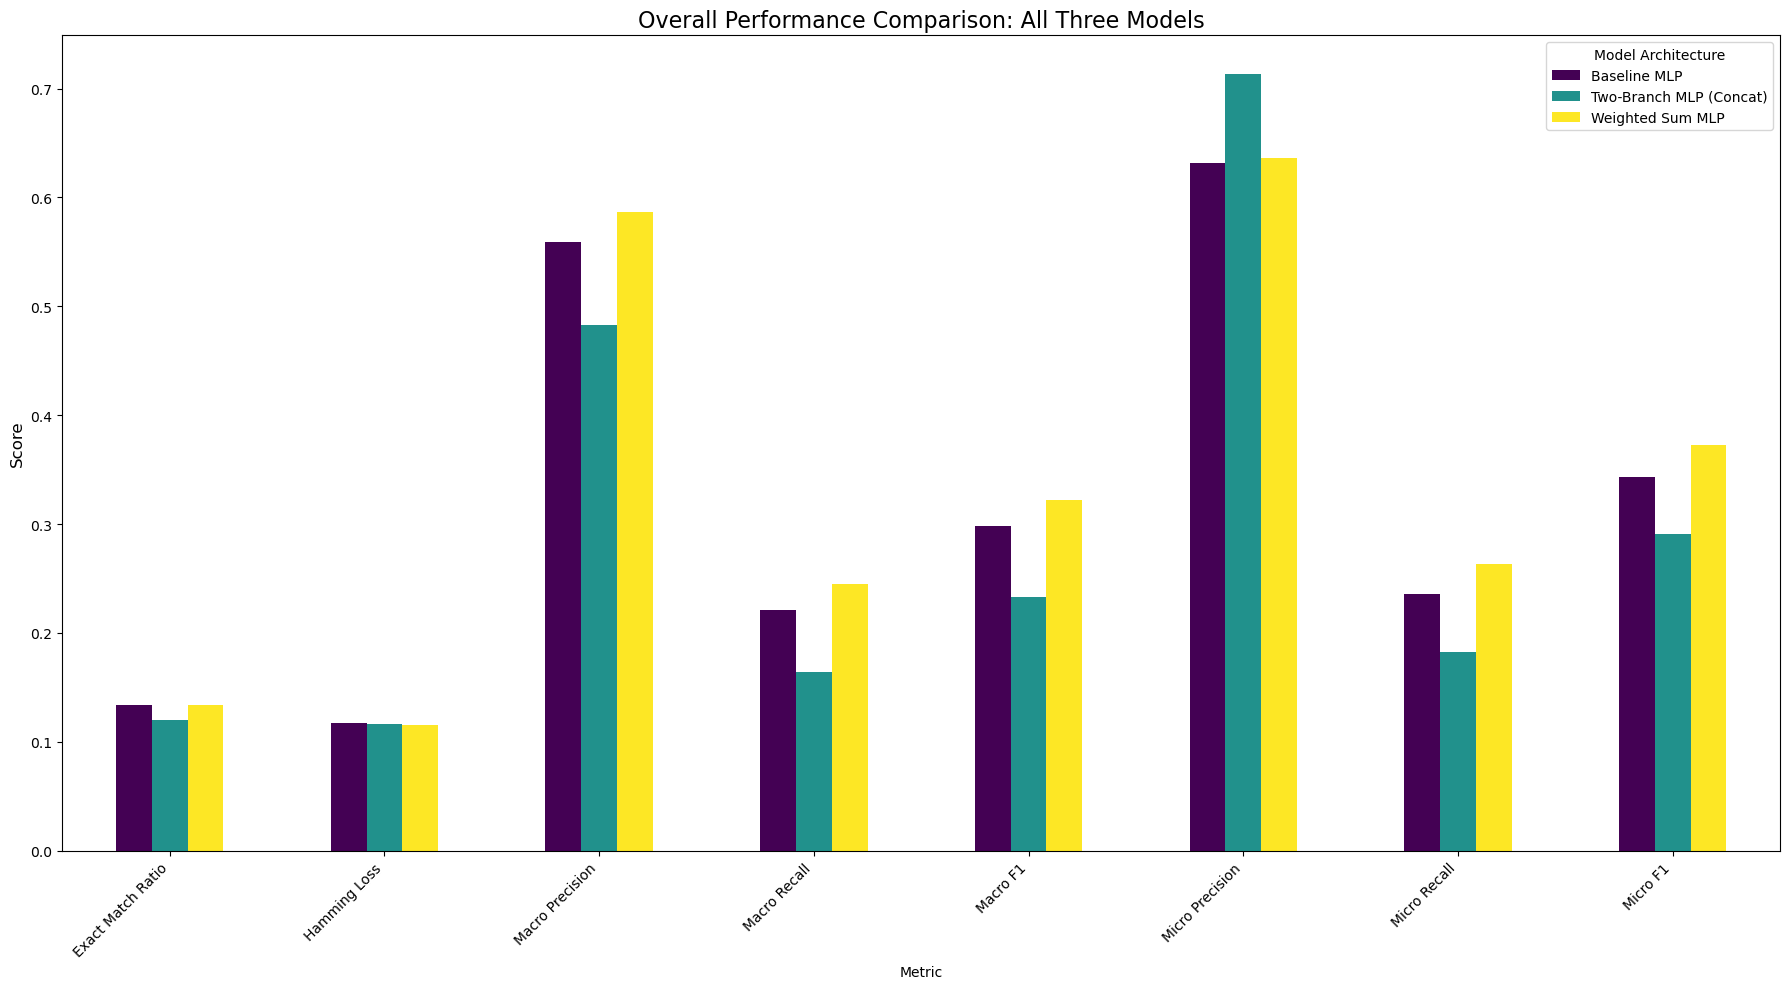

=== Per-Class F1-Score Comparison (All Three) ===
             Class  Baseline MLP F1  Two-Branch MLP (Concat) F1  Weighted Sum MLP F1
       Atelectasis         0.449438                    0.461538             0.566038
      Cardiomegaly         0.571429                    0.545455             0.555556
     Consolidation         0.057143                    0.000000             0.186047
             Edema         0.432432                    0.142857             0.457143
          Effusion         0.472727                    0.455446             0.508475
         Emphysema         0.431373                    0.470588             0.425532
          Fibrosis         0.000000                    0.000000             0.066667
            Hernia         0.620690                    0.461538             0.645161
      Infiltration         0.375000                    0.247191             0.291262
              Mass         0.190476                    0.055556             0.150000
            Nod

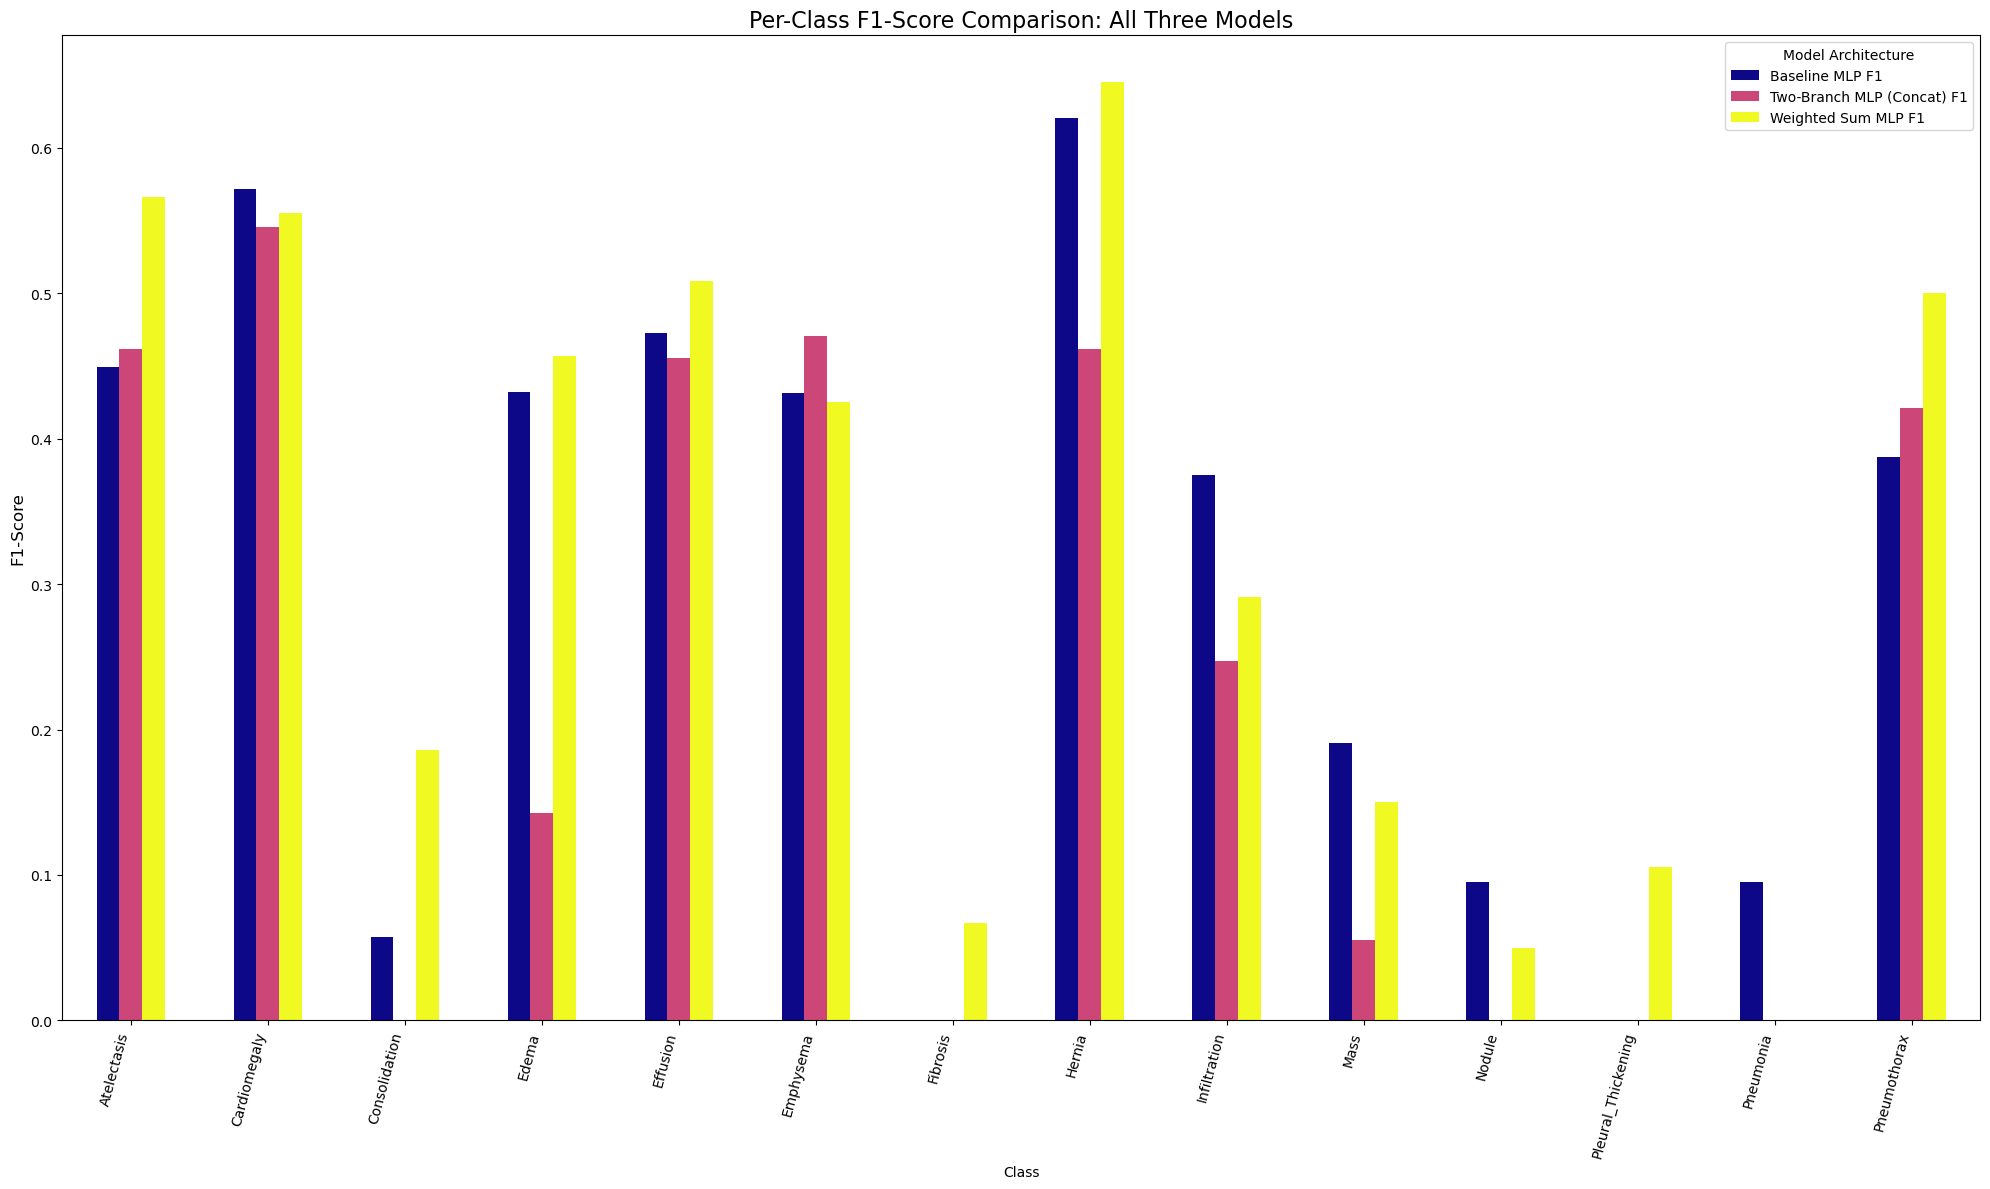

In [30]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load metrics from JSON files
baseline_metrics, baseline_class_metrics = None, None
two_branch_concat_metrics, two_branch_concat_class_metrics = None, None
weighted_sum_mlp_metrics, weighted_sum_mlp_class_metrics = None, None

try:
    with open('baseline_mlp_metrics.json', 'r') as f: baseline_metrics = json.load(f)
    with open('baseline_mlp_class_metrics.json', 'r') as f: baseline_class_metrics = json.load(f)
except FileNotFoundError: print("Baseline MLP metrics files not found.")

try:
    with open('all_metrics_comparison.json', 'r') as f: all_metrics_loaded = json.load(f)
    with open('all_class_metrics_comparison.json', 'r') as f: all_class_metrics_loaded = json.load(f)
    
    two_branch_concat_metrics = all_metrics_loaded.get("two_branch_mlp_concat")
    two_branch_concat_class_metrics = all_class_metrics_loaded.get("two_branch_mlp_concat")
    
    weighted_sum_mlp_metrics = all_metrics_loaded.get("weighted_sum_mlp")
    weighted_sum_mlp_class_metrics = all_class_metrics_loaded.get("weighted_sum_mlp")
except FileNotFoundError: print("Comparison metrics files ('all_metrics_comparison.json') not found.")

# Overall Metrics Comparison
if baseline_metrics and two_branch_concat_metrics and weighted_sum_mlp_metrics:
    overall_metrics_data = {
        'Metric': ['Exact Match Ratio', 'Hamming Loss', 'Macro Precision', 'Macro Recall', 'Macro F1', 'Micro Precision', 'Micro Recall', 'Micro F1'],
        'Baseline MLP': [baseline_metrics.get(m_key, 0) for m_key in ['exact_match_ratio', 'hamming_loss', 'macro_precision', 'macro_recall', 'macro_f1', 'micro_precision', 'micro_recall', 'micro_f1']],
        'Two-Branch MLP (Concat)': [two_branch_concat_metrics.get(m_key, 0) for m_key in ['exact_match_ratio', 'hamming_loss', 'macro_precision', 'macro_recall', 'macro_f1', 'micro_precision', 'micro_recall', 'micro_f1']],
        'Weighted Sum MLP': [weighted_sum_mlp_metrics.get(m_key, 0) for m_key in ['exact_match_ratio', 'hamming_loss', 'macro_precision', 'macro_recall', 'macro_f1', 'micro_precision', 'micro_recall', 'micro_f1']]
    }
    df_overall_metrics = pd.DataFrame(overall_metrics_data)
    print("=== Overall Metrics Comparison (All Three) ===")
    print(df_overall_metrics.to_string(index=False))

    df_plot_overall = df_overall_metrics.set_index('Metric')
    df_plot_overall.plot(kind='bar', figsize=(18, 10), colormap='viridis')
    plt.title('Overall Performance Comparison: All Three Models', fontsize=16)
    plt.ylabel('Score', fontsize=12); plt.xticks(rotation=45, ha='right'); plt.legend(title='Model Architecture')
    plt.tight_layout(); plt.savefig('overall_metrics_comparison_all_three.png'); plt.show()
else:
    print("Could not compare overall metrics due to missing data for one or more models.")

# Per-Class F1-Score Comparison
if baseline_class_metrics and two_branch_concat_class_metrics and weighted_sum_mlp_class_metrics: 
    baseline_f1 = {item['class']: item['f1'] for item in baseline_class_metrics}
    two_branch_f1 = {item['class']: item['f1'] for item in two_branch_concat_class_metrics}
    weighted_sum_f1 = {item['class']: item['f1'] for item in weighted_sum_mlp_class_metrics}
    
    all_classes = sorted(list(set(baseline_f1.keys()) | set(two_branch_f1.keys()) | set(weighted_sum_f1.keys())))
    
    f1_data = {
        'Class': all_classes,
        'Baseline MLP F1': [baseline_f1.get(c, 0) for c in all_classes],
        'Two-Branch MLP (Concat) F1': [two_branch_f1.get(c, 0) for c in all_classes],
        'Weighted Sum MLP F1': [weighted_sum_f1.get(c, 0) for c in all_classes]
    }
    df_f1_class = pd.DataFrame(f1_data)
    print("=== Per-Class F1-Score Comparison (All Three) ===")
    print(df_f1_class.to_string(index=False))

    df_plot_f1 = df_f1_class.set_index('Class')
    df_plot_f1.plot(kind='bar', figsize=(20, 12), colormap='plasma')
    plt.title('Per-Class F1-Score Comparison: All Three Models', fontsize=16)
    plt.ylabel('F1-Score', fontsize=12); plt.xticks(rotation=75, ha='right'); plt.legend(title='Model Architecture')
    plt.tight_layout(); plt.savefig('per_class_f1_comparison_all_three.png'); plt.show()
else:
    print("Could not compare per-class F1-scores due to missing data for one or more models.")

# Visualize Predictions for a Sample Image
This section loads a sample image and uses the three trained models to predict conditions. The results are then visualized.

Selected sample image with multiple potential findings: index 1
Using sample image: C:/Users/Admin/Desktop/Bagdanov Deep Learning/lab3/med_diag/dataset/images\00008051_009.png
True labels for sample image: Atelectasis|Consolidation
--- Visualizing Baseline MLP Prediction ---
Saved visualization to prediction_viz_baseline_mlp.png


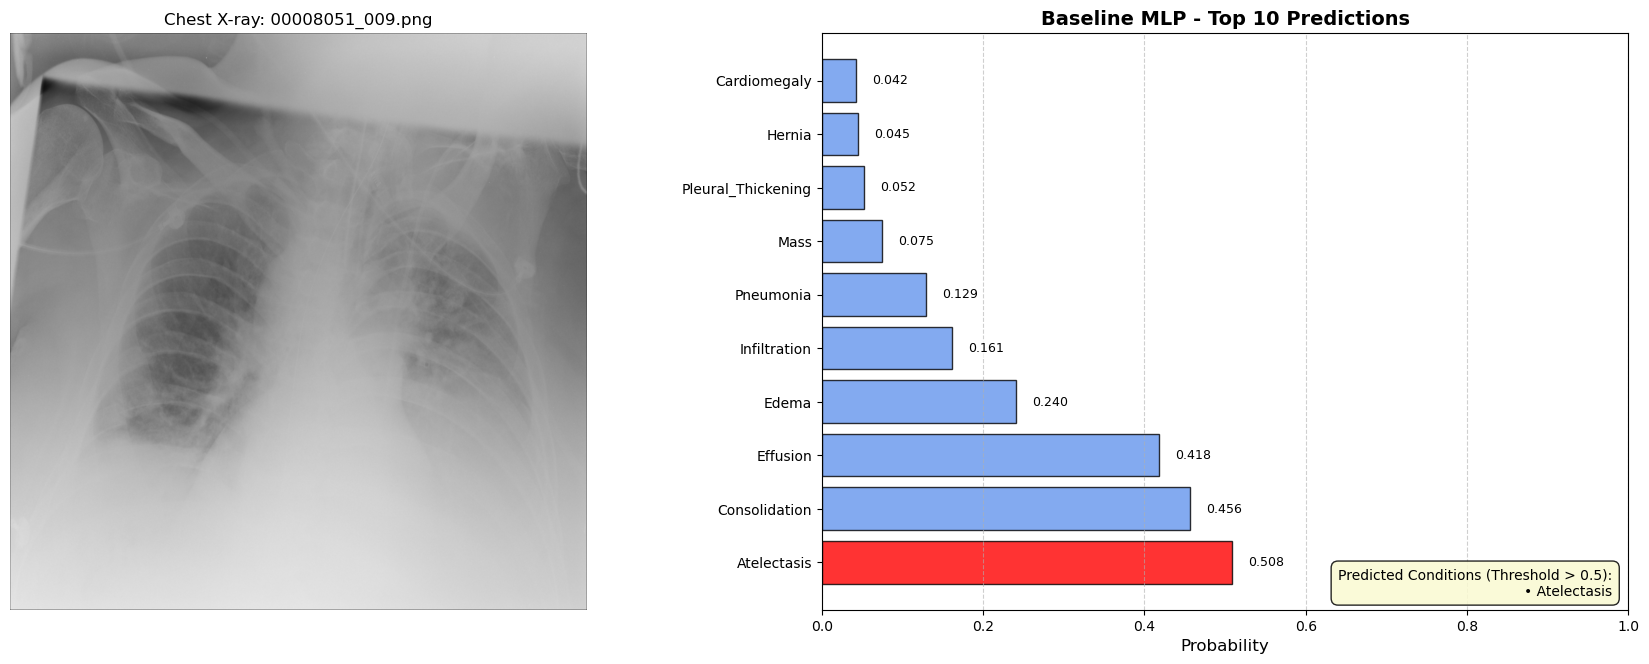

--- Visualizing Two-Branch MLP (Concat) Prediction ---
Saved visualization to prediction_viz_two_branch_mlp.png


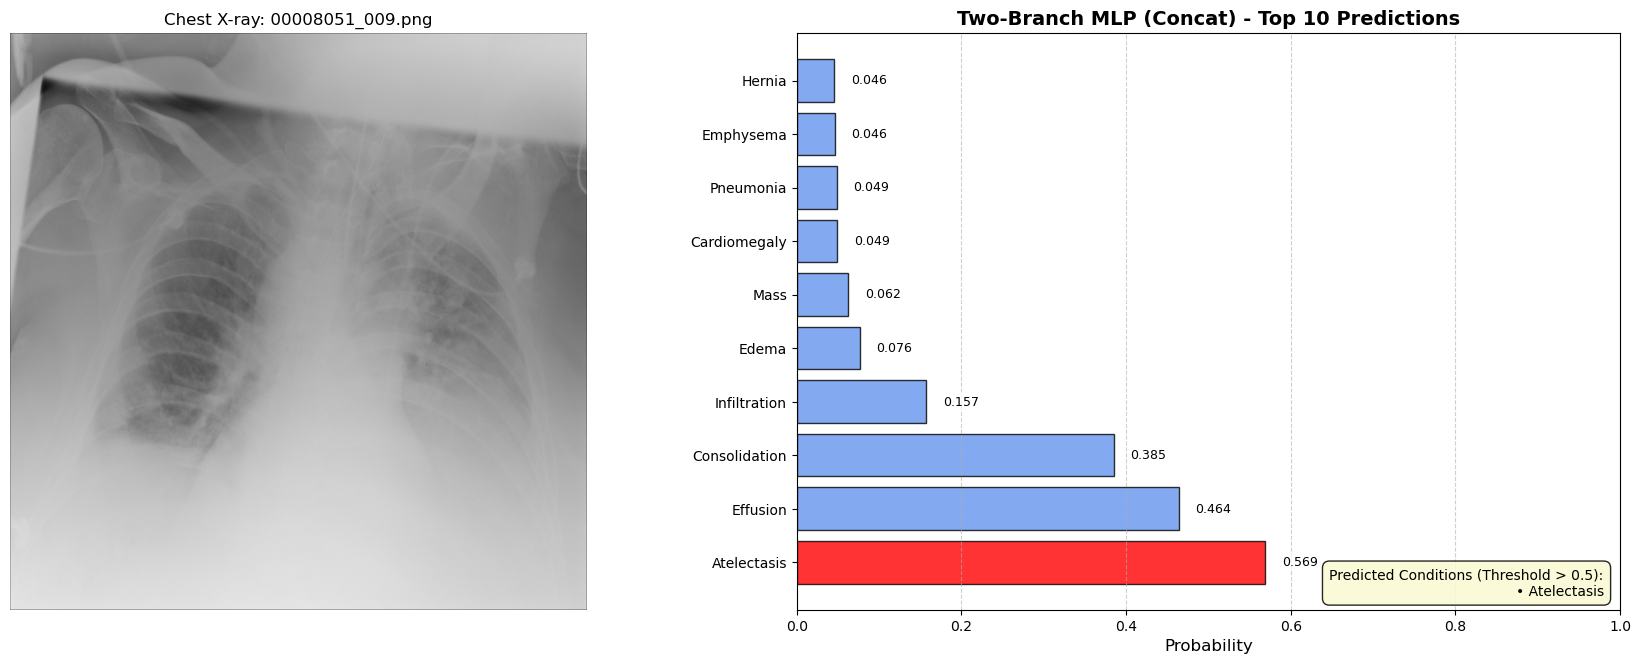

--- Visualizing Weighted Sum MLP Prediction ---
Saved visualization to prediction_viz_weighted_sum_mlp.png


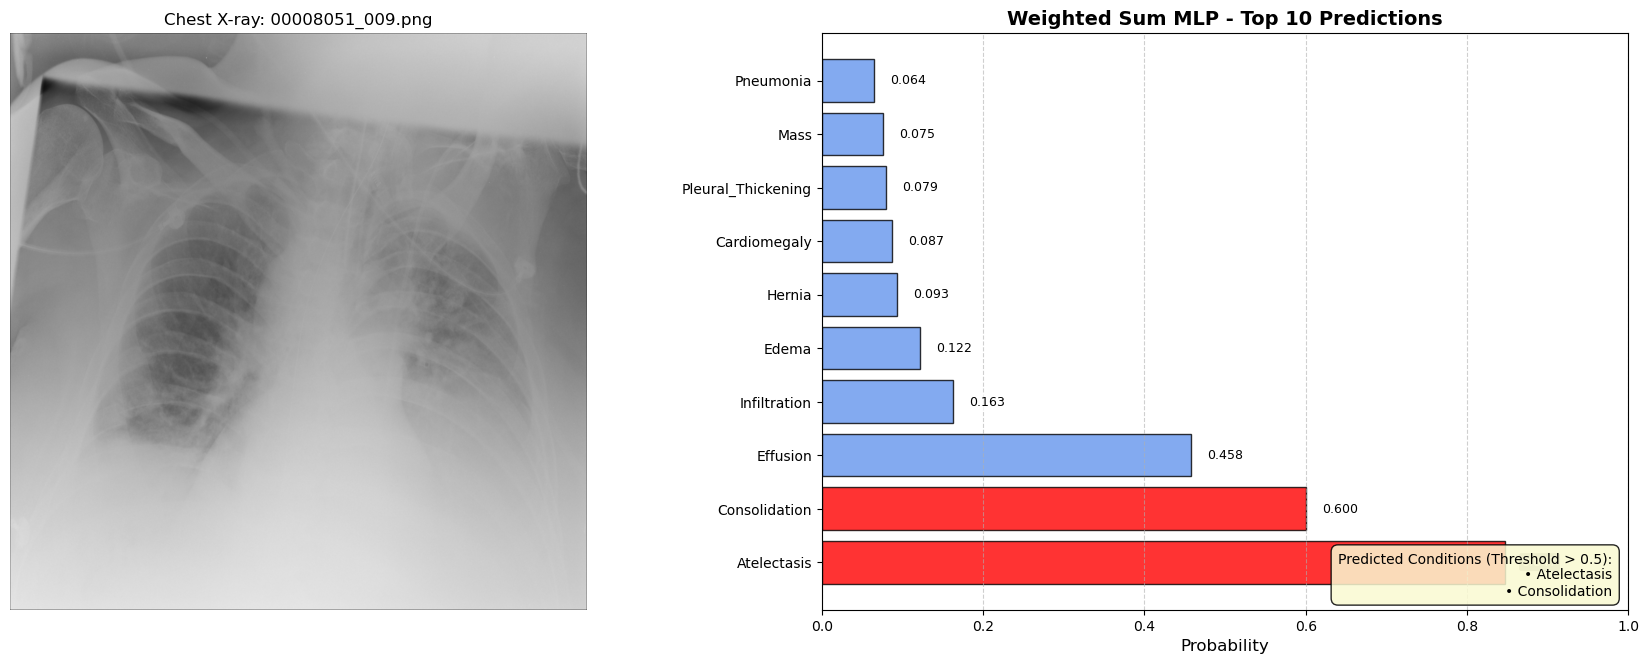

In [31]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_prediction(image_path, results, img=None, save_path=None, model_name="Model"):
    """
    Visualize prediction results for an image.
    
    Args:
        image_path: Path to the image
        results: Prediction results from predict_image_conditions
        img: PIL image (optional, will load if not provided)
        save_path: Path to save the visualization (optional)
        model_name: Name of the model for the title
    """
    if img is None:
        img = Image.open(image_path).convert("RGB")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7)) # Adjusted figsize
    
    # Display image
    ax1.imshow(img, cmap='gray')
    ax1.set_title(f'Chest X-ray: {os.path.basename(image_path)}', fontsize=12)
    ax1.axis('off')
    
    # Display predictions
    conditions = [pred['condition'] for pred in results['top_predictions']]
    probabilities = [pred['probability'] for pred in results['top_predictions']]
    # Ensure colors match logic: red if predicted (above threshold), blue otherwise
    colors = ['red' if pred['predicted'] else 'cornflowerblue' for pred in results['top_predictions']]


    bars = ax2.barh(range(len(conditions)), probabilities, color=colors, alpha=0.8, edgecolor='black')
    ax2.set_yticks(range(len(conditions)))
    ax2.set_yticklabels(conditions, fontsize=10)
    ax2.set_xlabel('Probability', fontsize=12)
    ax2.set_title(f'{model_name} - Top {len(conditions)} Predictions', fontsize=14, fontweight='bold')
    ax2.grid(True, axis='x', linestyle='--', alpha=0.6)
    ax2.set_xlim(0, 1) # Probabilities are between 0 and 1

    # Add probability labels to the side of the bars
    for i, (bar, prob) in enumerate(zip(bars, probabilities)):
        ax2.text(prob + 0.02, bar.get_y() + bar.get_height()/2, 
                f'{prob:.3f}', va='center', fontsize=9, 
                color='black' if prob < 0.8 else 'white', # Adjust text color for visibility
                bbox=dict(boxstyle="round,pad=0.2", fc='white' if prob < 0.8 else 'dimgray', ec="none", alpha=0.7 if prob < 0.8 else 0.5))

    # Add predicted conditions text block
    if results['predicted_conditions']:
        predicted_text = "Predicted Conditions (Threshold > 0.5):\n" + "\n".join([f"• {cond}" for cond in results['predicted_conditions']])
    else:
        predicted_text = "No conditions predicted\n(all probabilities below threshold 0.5)"
    
    ax2.text(0.98, 0.02, predicted_text, transform=ax2.transAxes, 
            fontsize=10, verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgoldenrodyellow", alpha=0.85))
    
    plt.tight_layout(pad=2.0) # Add some padding
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved visualization to {save_path}")
    
    plt.show()

# --- Select a sample image ---
# Ensure df_balanced and image_dir are available from previous cells
if 'df_balanced' in globals() and 'image_dir' in globals() and len(df_balanced) > 0:
    sample_image_idx = 0 # Or any other index
    # Let's pick an image that might have multiple findings for better visualization
    # Example: df_balanced[df_balanced['Finding Labels'].str.contains('\\|')].index[0]
    try:
        multi_finding_indices = df_balanced[df_balanced['Finding Labels'].str.count('\\|') > 0].index
        if len(multi_finding_indices) > 0:
            sample_image_idx = multi_finding_indices[0]
            print(f"Selected sample image with multiple potential findings: index {sample_image_idx}")
        else:
            print(f"No images with multiple findings in df_balanced, using index {sample_image_idx}")
    except Exception as e:
        print(f"Error selecting multi-finding image, defaulting to index {sample_image_idx}: {e}")

    sample_image_name = df_balanced['Image Index'][sample_image_idx]
    sample_image_path = os.path.join(image_dir, sample_image_name)
    print(f"Using sample image: {sample_image_path}")
    print(f"True labels for sample image: {df_balanced['Finding Labels'][sample_image_idx]}")

    # Ensure necessary variables for model instantiation and prediction are available
    # These should be defined in previous cells:
    # X_train, y_train (for dimensions), mlb, device, clip_model, clip_processor
    # prompt_mega_vector_flat_concat, prompt_mega_vector_flat_ws

    if not all(v in globals() for v in ['X_train', 'y_train', 'mlb', 'device', 'clip_model', 'clip_processor', 'prompt_mega_vector_flat_concat', 'prompt_mega_vector_flat_ws']):
        print("Error: Not all required variables for visualization are defined. Please run previous cells.")
    else:
        # --- Visualization Parameters ---
        PREDICTION_THRESHOLD = 0.5
        TOP_K_DISPLAY = 10 # Display top 10 predictions, or all if fewer than 10 classes

        # --- 1. Baseline MLP Visualization ---
        print("--- Visualizing Baseline MLP Prediction ---")
        input_dim_baseline = X_train.shape[1]
        num_classes_baseline = y_train.shape[1]
        hidden_dims_baseline = [512, 256, 128] # Must match the trained model
        
        baseline_mlp_viz = MLPClassifier(input_dim_baseline, hidden_dims_baseline, num_classes_baseline).to(device)
        baseline_mlp_viz.load_state_dict(torch.load('best_mlp_model.pth', map_location=device))
        baseline_mlp_viz.eval()
        
        results_baseline, img_baseline = predict_image_conditions(
            sample_image_path, baseline_mlp_viz, clip_model, clip_processor, mlb, device, 
            threshold=PREDICTION_THRESHOLD, top_k=TOP_K_DISPLAY
        )
        visualize_prediction(sample_image_path, results_baseline, img_baseline, 
                             save_path='prediction_viz_baseline_mlp.png', model_name="Baseline MLP")

        # --- 2. Two-Branch MLP (Concatenation Fusion) Visualization ---
        print("--- Visualizing Two-Branch MLP (Concat) Prediction ---")
        image_feat_dim_tb = X_train.shape[1]
        # Ensure prompt_mega_vector_flat_concat is 2D [1, dim] before accessing .shape[1]
        current_prompt_flat_concat = prompt_mega_vector_flat_concat
        if current_prompt_flat_concat.ndim == 1: current_prompt_flat_concat = current_prompt_flat_concat.unsqueeze(0)

        prompt_feat_flat_dim_tb = current_prompt_flat_concat.shape[1]
        hidden_dim_tb = 256 # Must match the trained model
        num_classes_tb = y_train.shape[1]
        
        two_branch_mlp_viz = TwoBranchMLP(image_feat_dim_tb, prompt_feat_flat_dim_tb, hidden_dim_tb, num_classes_tb).to(device)
        two_branch_mlp_viz.load_state_dict(torch.load('best_two_branch_mlp_concat_model.pth', map_location=device))
        two_branch_mlp_viz.eval()
        
        prompt_features_for_viz_tb = current_prompt_flat_concat.to(device) # Already flattened and unsqueezed
        
        results_tb, img_tb = predict_image_conditions(
            sample_image_path, two_branch_mlp_viz, clip_model, clip_processor, mlb, device,
            threshold=PREDICTION_THRESHOLD, top_k=TOP_K_DISPLAY, prompt_features_inf=prompt_features_for_viz_tb
        )
        visualize_prediction(sample_image_path, results_tb, img_tb, 
                             save_path='prediction_viz_two_branch_mlp.png', model_name="Two-Branch MLP (Concat)")

        # --- 3. Weighted Sum MLP Visualization ---
        print("--- Visualizing Weighted Sum MLP Prediction ---")
        image_feat_dim_ws_viz = X_train.shape[1]
        
        current_prompt_flat_ws = prompt_mega_vector_flat_ws
        if current_prompt_flat_ws.ndim == 1: current_prompt_flat_ws = current_prompt_flat_ws.unsqueeze(0)

        prompt_feat_flat_dim_ws_viz = current_prompt_flat_ws.shape[1]
        mlp_hidden_dims_ws_viz = [512, 256] # Must match the trained model
        num_classes_ws_viz = y_train.shape[1]
        
        weighted_sum_mlp_viz = WeightedSumMLP(image_feat_dim_ws_viz, prompt_feat_flat_dim_ws_viz, mlp_hidden_dims_ws_viz, num_classes_ws_viz).to(device)
        weighted_sum_mlp_viz.load_state_dict(torch.load('best_weighted_sum_mlp_model.pth', map_location=device))
        weighted_sum_mlp_viz.eval()
        
        prompt_features_for_viz_ws = current_prompt_flat_ws.to(device) # Already flattened and unsqueezed
        
        results_ws, img_ws = predict_image_conditions(
            sample_image_path, weighted_sum_mlp_viz, clip_model, clip_processor, mlb, device,
            threshold=PREDICTION_THRESHOLD, top_k=TOP_K_DISPLAY, prompt_features_inf=prompt_features_for_viz_ws
        )
        visualize_prediction(sample_image_path, results_ws, img_ws, 
                             save_path='prediction_viz_weighted_sum_mlp.png', model_name="Weighted Sum MLP")
else:
    print("Could not run visualization due to missing df_balanced or image_dir, or df_balanced is empty.")
